In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.modeling import models, fitting
from photutils.aperture import CircularAperture, EllipticalAperture
from photutils.aperture import aperture_photometry

%matplotlib inline
#%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')
plt.rcParams['axes.grid'] = False

In [2]:
# Function to open the fits file and plot them
def Open_Fits(filepath, plot, cmap='gnuplot2'):
    file_temp = fits.open(filepath)
    file = file_temp[0].data
    file_temp.close()
    if plot == True:
        plt.imshow(file, clim=(0, np.quantile(file, [0.99])), cmap=cmap, origin='lower')
        plt.colorbar(fraction=0.0375, pad=0.02);
    return file

# Lecture notes

The following extract comes from the lecture notes of the 'Introduction to Galaxies' course of M.Fumagalli and M.Fossati


<div>
<img src="Data/Dust_lecture_notes.png" width="1000"/>
</div>

# Ratio of Ha and Hb

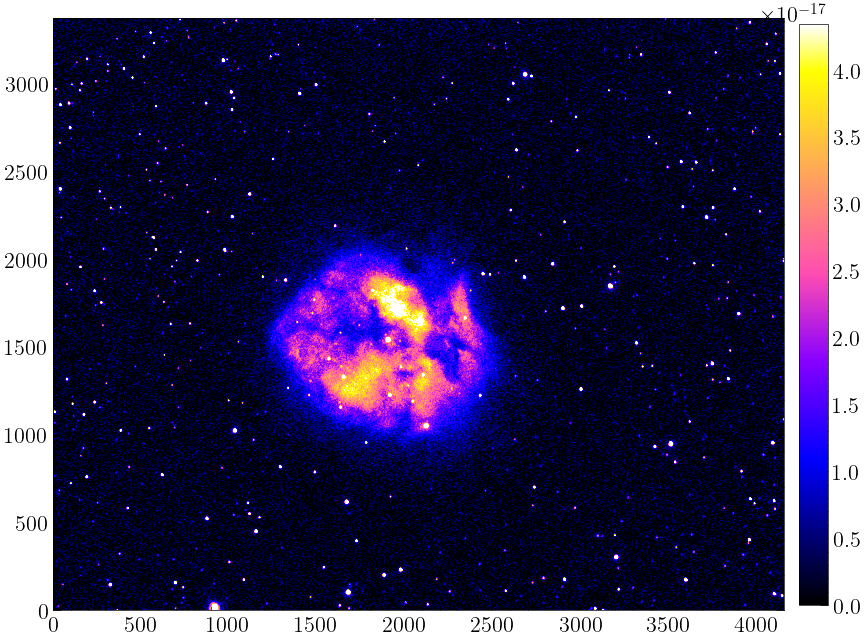

In [3]:
final_Ha_physical = Open_Fits(filepath='Data/final_Ha_physical.fits', plot=True)

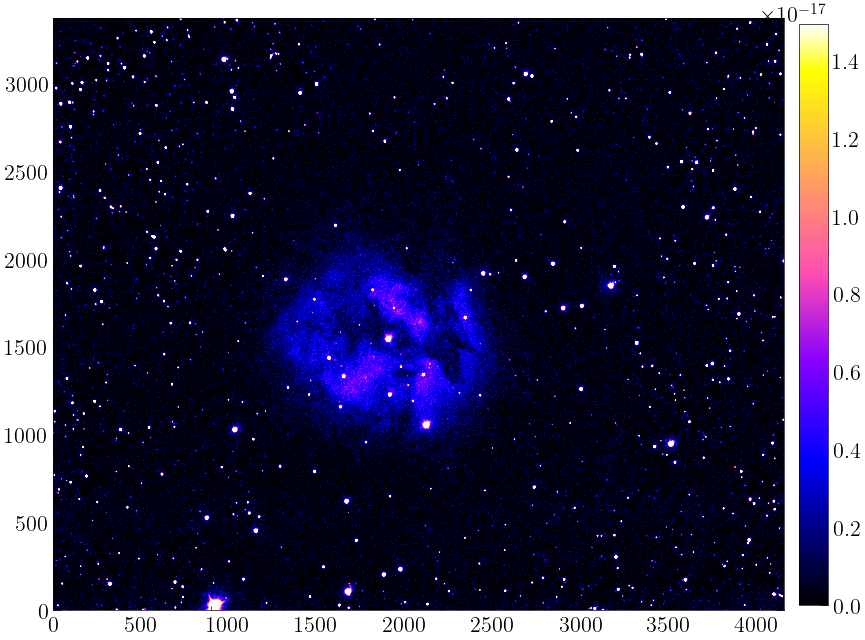

In [4]:
final_Hb_physical = Open_Fits(filepath='Data/final_Hb_physical.fits', plot=True)

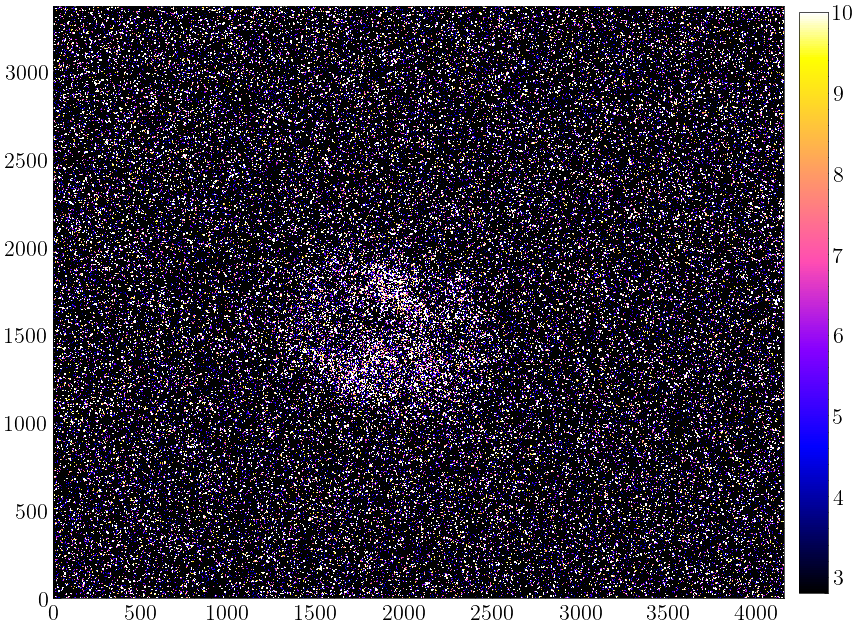

In [5]:
ratio_Ha_Hb = final_Ha_physical / final_Hb_physical

plt.imshow(ratio_Ha_Hb, clim=(2.8,10), cmap='gnuplot2', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);

In [6]:
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

gauss_kernel = Gaussian2DKernel(2, 2)

ratio_Ha_Hb_smoothed = convolve_fft(final_Ha_physical, gauss_kernel) / convolve_fft(final_Hb_physical, gauss_kernel)

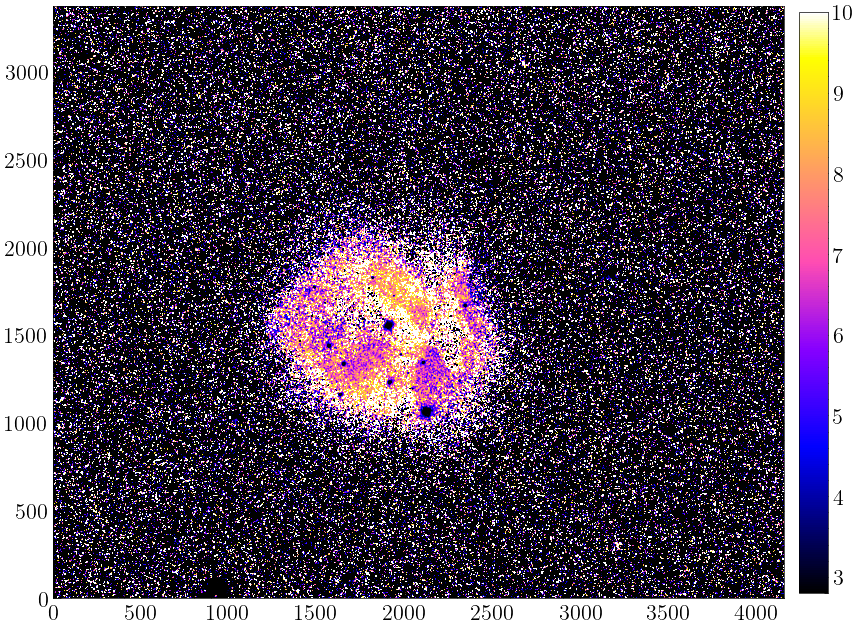

In [7]:
plt.imshow(ratio_Ha_Hb_smoothed, clim=(2.8,10), cmap='gnuplot2', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);

## Computing $E(B-V)$

The following extract comes from 'J-PLUS: Measuring Hα emission line fluxes in the nearby universe' by Logroño-García et al (https://doi.org/10.1051/0004-6361/201732487).

<div>
<img src="Data/Dust_HaHbRatio.png" width="600"/>
</div>

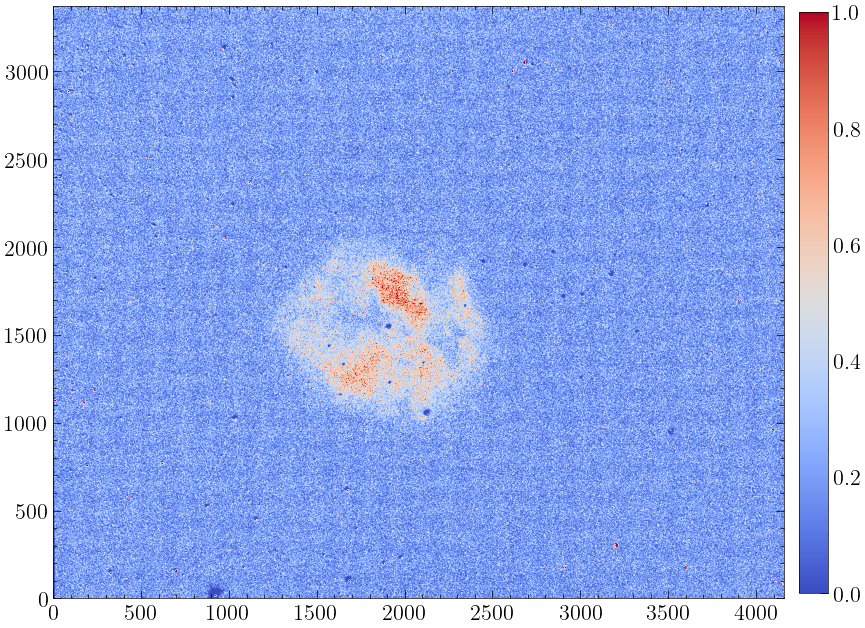

In [8]:
def EBV(image):
    image [image < 2.86] = 2.86
    return 1.97*np.log10(image/2.86)

EBV_Ha_Hb = EBV(ratio_Ha_Hb)

plt.imshow(EBV_Ha_Hb, clim=(0, 1), cmap='coolwarm', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);

## Estimating the emitted flux

The observed flux, equal to the emitted flux minus the filtered flux, is given by the formula (Calzetti, 2000):

$$f_{obs}(\lambda) = f_{emit}(\lambda) \times 10^{-0.4 \times k(\lambda) \times E(B-V)}$$

$$k(\lambda) = 
\begin{cases}
      2.659 \times (-2.156+\frac{1.509}{\lambda}-\frac{10.198}{\lambda^2}+\frac{0.011}{\lambda^3}) + 4.05 \:\:\:\:\: & for \:\: 0.12\mu m \leq \lambda \leq 0.63\mu m \\
      2.659 \times (-1.857+\frac{1.040}{\lambda}) + 4.05 & for \:\: 0.63\mu m < \lambda \leq 2.20\mu m
\end{cases}$$

The term $E(B-V) \in [0,1]$ describes the amount of dust. In particular, $E(B-V)=0$ corresponds to zero dust attenuation, while $E(B-V)=1$ means maximum dust attenuation.

k_{Calzetti} = 3.31


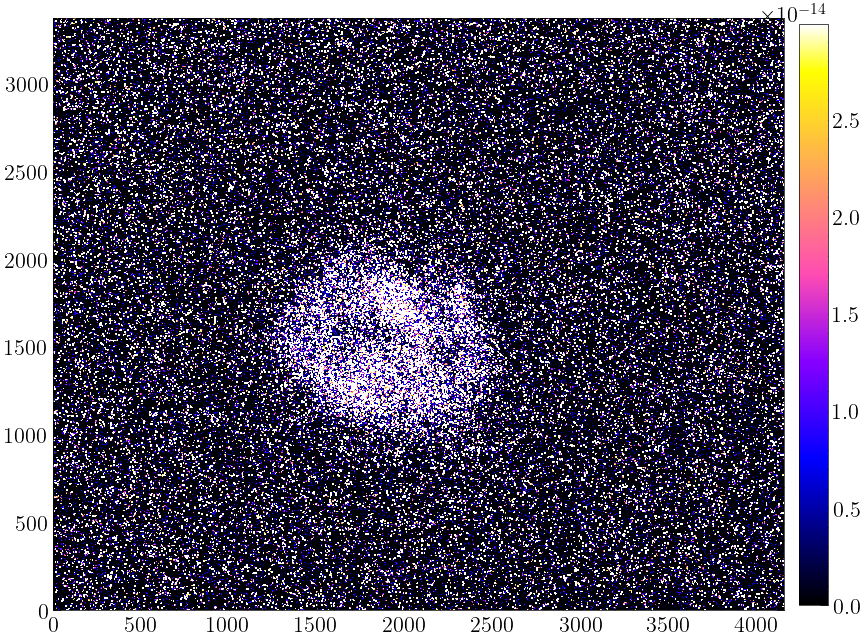

In [9]:
def dust_att_k(wav):
    wav_um = wav/(10**4)
    k1 = 2.659*(-2.156 + 1.509/wav_um - 0.198/(wav_um**2) + 0.011/(wav_um**3)) + 4.05
    k2 = 2.659*(-1.857 + 1.040/wav_um) + 4.03 
    k = np.where(wav_um<=0.63, k1, k2)
    return k

def Emitted_Flux(image, wav, EBV):
    k = dust_att_k(wav)
    print(f'k_{{Calzetti}} = {k:.2f}')
    return image*10**(0.4*k*EBV)

Emitted_Ha = Emitted_Flux(final_Ha_physical, 6563, EBV_Ha_Hb)
plt.imshow(Emitted_Ha, clim=(0, np.quantile(Emitted_Ha, [0.99])), cmap='gnuplot2', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);

k_{Calzetti} = 4.60


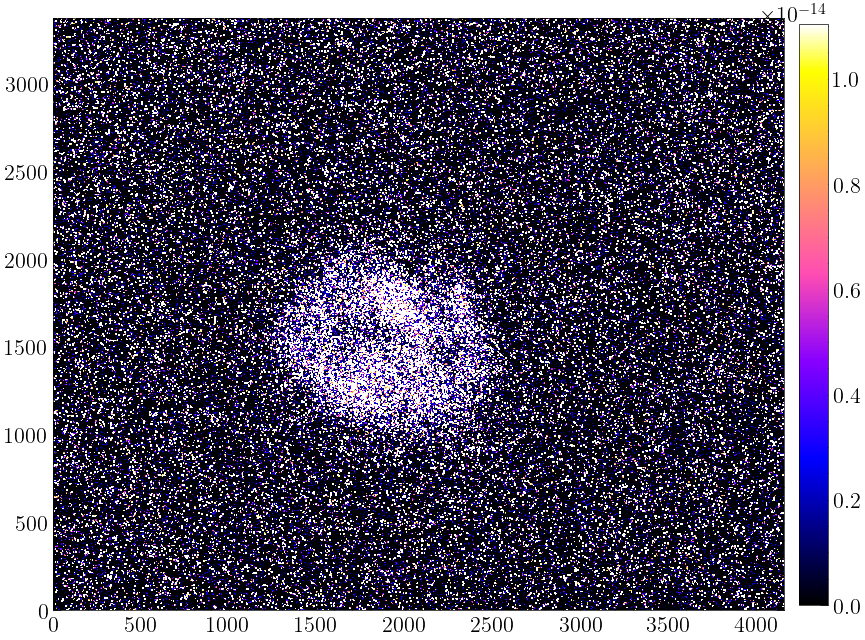

In [10]:
Emitted_Hb = Emitted_Flux(final_Hb_physical, 4861, EBV_Ha_Hb)
plt.imshow(Emitted_Hb, clim=(0, np.quantile(Emitted_Hb, [0.99])), cmap='gnuplot2', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);

# Masking the stars

In [11]:
final_Ha_radec = fits.open('Data/final_Ha_radec.fits')[1].data

In [12]:
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/355/gaiadr3
# Constraints: 328.25 < RA < 328.5     47.2 < DEC < 47.35     Gmag < 18
GAIA_catalogue = fits.open('Data/GAIA_catalogue_whithin_nebula.fit')[1].data

We are going to perform aperture photometry on 29 stars


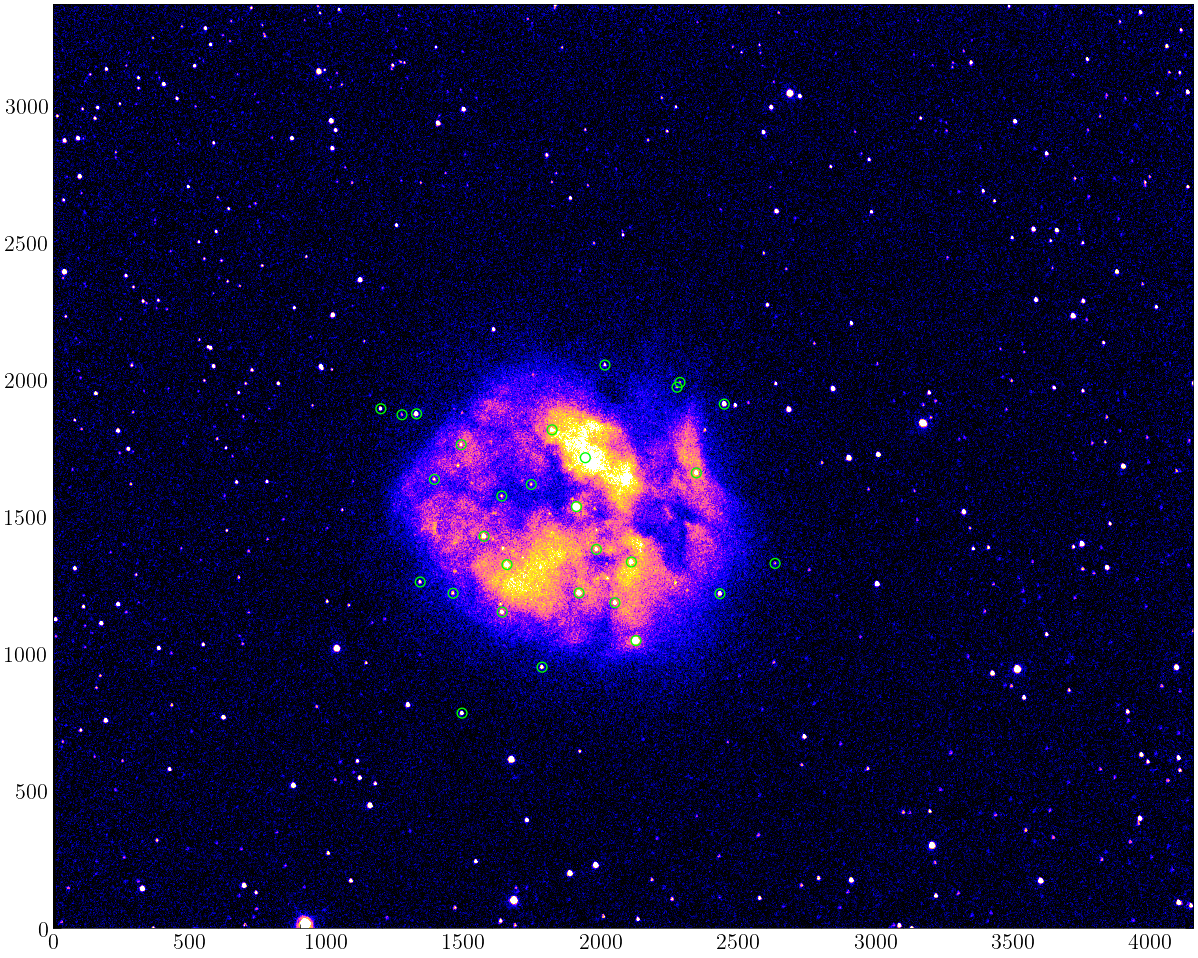

In [13]:
stars_x = []
stars_y = []
stars_Gaianame = []
stars_Gmag = []

for i in range(len(GAIA_catalogue['RA_ICRS'])):
    # Consider only the stars that are bright enough
    if GAIA_catalogue['Gmag'][i] < 15:
        # Find the matches between GAIA stars and our stars
        # If there is only one match, append the coordinates (from astrometry.net) and magnitudes (from GAIA catalogue)
        # If there is no match or more than one match, do nothing
        mask_ra = np.isclose(final_Ha_radec['ra'], GAIA_catalogue['RA_ICRS'][i], atol=0, rtol=0.000002)
        mask_dec = np.isclose(final_Ha_radec['dec'], GAIA_catalogue['DE_ICRS'][i], atol=0, rtol=0.000002)
        mask_tot = np.logical_and(mask_ra, mask_dec)
        if np.sum(mask_tot) == 1:
            stars_x.append(final_Ha_radec['x'][mask_tot][0])
            stars_y.append(final_Ha_radec['y'][mask_tot][0])
            stars_Gaianame.append(GAIA_catalogue['Source'][i])
            stars_Gmag.append(GAIA_catalogue['Gmag'][i])
        
stars_x = np.array(stars_x)
stars_y = np.array(stars_y)
stars_Gaianame = np.array(stars_Gaianame)
stars_Gmag = np.array(stars_Gmag)
        
plt.figure(figsize=(18,12))
plt.imshow(final_Ha_physical, clim=(0, np.quantile(final_Ha_physical, [0.99])), cmap='gnuplot2', origin='lower')

for i in range(len(stars_x)):
    plt.scatter(stars_x[i], stars_y[i], facecolors='none', edgecolors='lime', s=50)
    
print(f'We are going to perform aperture photometry on {len(stars_Gaianame)} stars')

In [14]:
def Mask_Stars(image, stars_x, stars_y, stars_Gaianame, stars_Gmag, plot=False, rectangle_side=20, fwhm_factor=3):
    
    N = len(stars_x)
    
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    mask_stars = image==image
    
    fig, ax = plt.subplots(figsize=(18,12))
    ax.imshow(image, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
    
    if plot==True:
        if N % 8 == 0:
            fig_2, axes_2 = plt.subplots(int(N/8), 8, figsize=(24, 4*int(N/8)))
        else:
            fig_2, axes_2 = plt.subplots(int(N/8)+1, 8, figsize=(24, 4*(int(N/8)+1)))


    for i in range(N):
        rectangle_side_i = rectangle_side*(14/stars_Gmag[i])
        cutout = image[round(stars_y[i]-rectangle_side_i/2):round(stars_y[i]+rectangle_side_i/2), round(stars_x[i]-rectangle_side_i/2):round(stars_x[i]+rectangle_side_i/2)]

        # 1) Compute the FWHM of the stars to decide the radius of the circular aperture   
        y, x = np.mgrid[:cutout.shape[0], :cutout.shape[1]]
        gaussian_init = models.Gaussian2D(amplitude=np.max(cutout), 
                                          x_mean=cutout.shape[0]/2, 
                                          y_mean=cutout.shape[1]/2, 
                                          x_stddev=cutout.shape[0]/5, 
                                          y_stddev=cutout.shape[1]/5)
        gaussian_fit = fitting.LevMarLSQFitter()
        fitted_gaussian = gaussian_fit(gaussian_init, x, y, cutout)
        mean_x = fitted_gaussian.x_mean.value
        fwhm_x = 2.355*fitted_gaussian.x_stddev.value
        mean_y = fitted_gaussian.y_mean.value
        fwhm_y = 2.355*fitted_gaussian.y_stddev.value
        
            
        # 2) Redefine the centroid and define the aperture radius
        # the cutout frame, in which mean_x and mean_y are defined, is centered on the left-bottom corner of the rectangle
        aperture_centroid = [round(stars_x[i]-rectangle_side_i/2)+mean_x, round(stars_y[i]-rectangle_side_i/2)+mean_y]
        # the aperture radius is a radius, and thus we must divide the FWHM by 2!
        aperture_r = fwhm_factor*np.mean([fwhm_x/2, fwhm_y/2])
        
        
        # 3) Define the circular masks
        dist_from_center = np.sqrt((X - aperture_centroid[0])**2 + (Y-aperture_centroid[1])**2)
        mask_star = dist_from_center <= aperture_r
        mask_stars = np.logical_and(mask_stars, ~mask_star)

        
        # 4) Plot the resulting apertures on the image
        circle_plot = plt.Circle(aperture_centroid, aperture_r, color='lime', linewidth=0.8, fill=False)
        ax.add_patch(circle_plot)
        ax.text(aperture_centroid[0]+1.5*aperture_r, aperture_centroid[1]-0.8*aperture_r, f'{i}', fontsize=15, color='lime')
        
        
        # 5) Plot the cutouts
        if plot==True:
            ax_2 = axes_2.flatten()[i]
            ax_2.set_title(f'Star {i}: {stars_Gaianame[i]} \n ', fontsize=11)
            ax_2.imshow(cutout, clim=(0, np.quantile(cutout, [0.99])), cmap='gnuplot2', origin='lower')
            circle_plot = plt.Circle([mean_x, mean_y], aperture_r, color='lime', linewidth=1.5, fill=False)
            ax_2.add_patch(circle_plot)
        
            # Remove the unused axes (actually, it does not work)
            for i in range(N % 8):
                axes_2.flatten()[-1-i].axis('off')
    
    return mask_stars

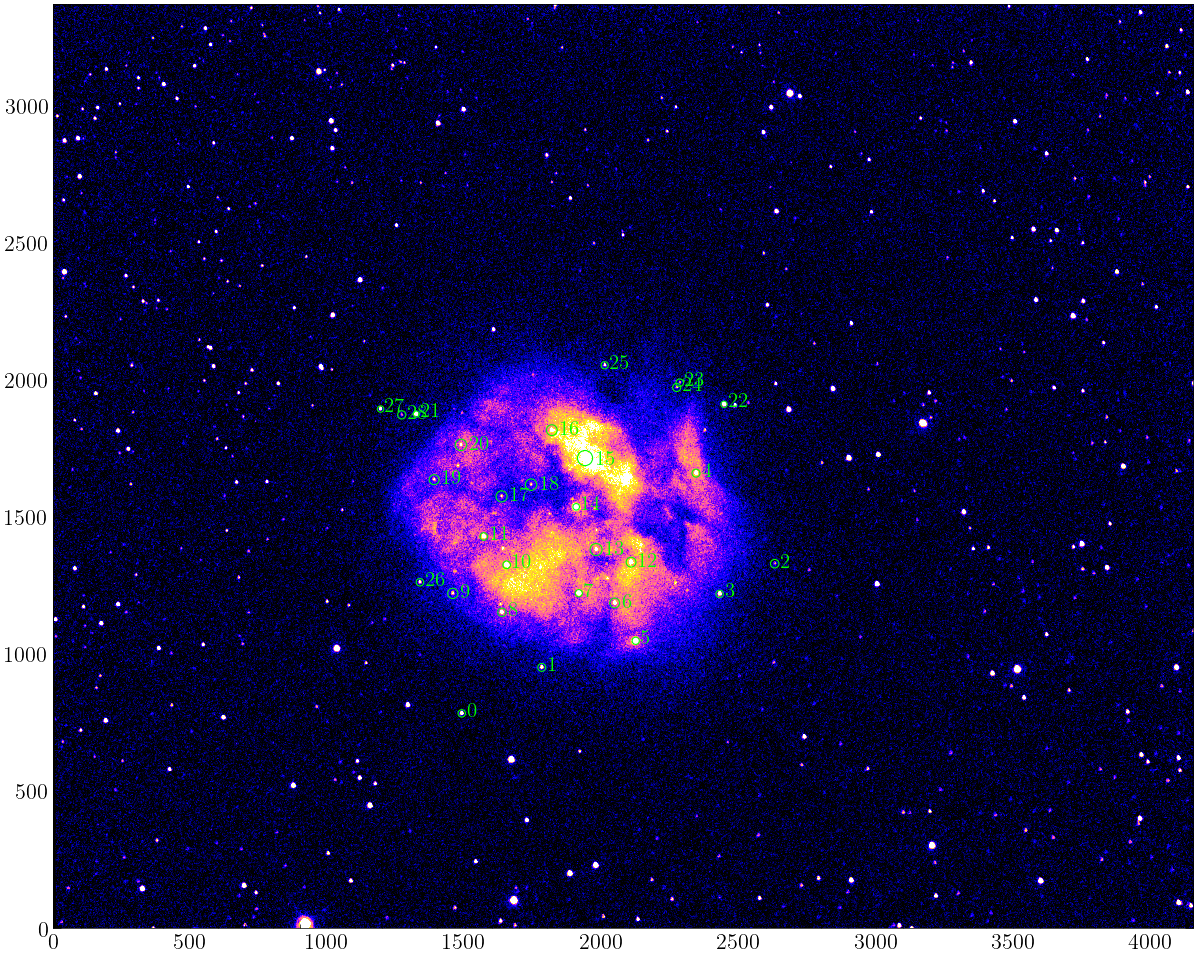

In [15]:
mask_stars = Mask_Stars(final_Ha_physical, stars_x, stars_y, stars_Gaianame, stars_Gmag, plot=False)

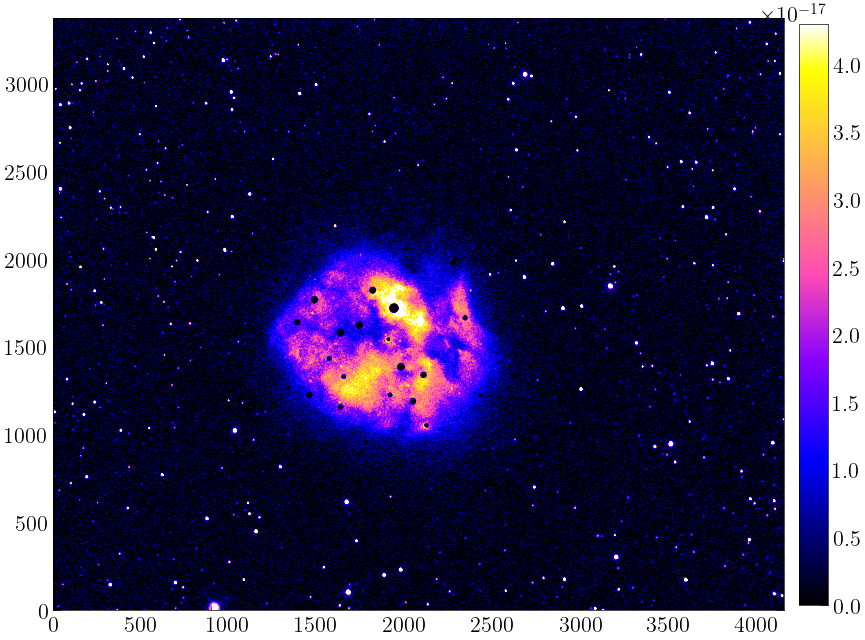

In [16]:
final_Ha_physical_masked = final_Ha_physical.copy()
final_Ha_physical_masked[~mask_stars] = 1e-20

plt.imshow(final_Ha_physical_masked, clim=(0, np.quantile(final_Ha_physical_masked, [0.99])), cmap='gnuplot2', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);